# Importing Repositories

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import holidays
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize']=(20,10)

In [2]:
def missing_zero_values_table(df):
        ''''Takes a pandas dataframe and returns a statistics table that explains the missing and 
        zero values'''
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Our selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    
        return mz_table

# Importing data files

## Paths for files

In [3]:
path_price = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadPrices_12.1.D'
path_totalload = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadTotalLoadForecast'
path_windsolar = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadGenerationForecastForWindAndSolar_14.1.D'

## Price Timeseries Importing

In [4]:

df_price = pd.read_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\price_timeseries_outliers.csv', 
parse_dates=['DateTime'])


In [5]:
df_price = df_price[['DateTime', 'Year', 'Month','Week', 'Day', 'Hour', 'Price', 'Outlier']]
df_price

,DateTime,Year,Month,Week,Day,Hour,Price,Outlier
0,2015-01-01 00:00:00,2015,1,1,3,0,0.00,N
1,2015-01-01 01:00:00,2015,1,1,3,1,0.00,N
2,2015-01-01 02:00:00,2015,1,1,3,2,0.00,N
3,2015-01-01 03:00:00,2015,1,1,3,3,0.00,N
4,2015-01-01 04:00:00,2015,1,1,3,4,0.00,N
...,...,...,...,...,...,...,...,...
52529,2020-12-31 18:00:00,2020,12,53,3,18,71.30,N
52530,2020-12-31 19:00:00,2020,12,53,3,19,61.04,N
52531,2020-12-31 20:00:00,2020,12,53,3,20,60.39,N
52532,2020-12-31 21:00:00,2020,12,53,3,21,57.96,N


## Wind and Solar Timeseries Importing

In [6]:
f_windsolar = glob.glob(path_windsolar + "/*.csv")
dwindsolar = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windsolar]

df_windsolar = pd.concat(dwindsolar)
df_windsolar = df_windsolar[df_windsolar['AreaCode'] == '10YGB----------A']
df_windsolar = df_windsolar[['DateTime', 'ProductionType', 'AggregatedGenerationForecast']]
df_windsolar.sort_values(by='DateTime', ascending=True)
df_windsolar.reset_index(drop=True, inplace=True)

In [7]:
df_windsolar

,DateTime,ProductionType,AggregatedGenerationForecast
0,2014-12-30 00:00:00,Solar,0.00
1,2014-12-30 01:00:00,Solar,0.00
2,2014-12-30 02:00:00,Solar,0.00
3,2014-12-30 03:00:00,Solar,0.00
4,2014-12-30 04:00:00,Solar,0.00
...,...,...,...
509107,2021-06-14 19:00:00,Wind Offshore,1563.23
509108,2021-06-14 20:00:00,Wind Offshore,1590.47
509109,2021-06-14 21:00:00,Wind Offshore,1574.14
509110,2021-06-14 22:00:00,Wind Offshore,1450.72


### Splitting the WindSolar Dataset into 3 Datasets per Solar, Wind Offshore, Wind Onshore

In [8]:
df_windsolar['ProductionType'].unique()

array(['Solar', 'Wind Offshore', 'Wind Onshore'], dtype=object)

In [9]:
df_solar = df_windsolar[df_windsolar['ProductionType'] == 'Solar']
df_solar.sort_values(by='DateTime', ascending=True)
df_solar.reset_index(drop=True, inplace=True)
df_solar.rename(columns={'AggregatedGenerationForecast':'SolarGeneration'}, inplace=True)
df_solar = df_solar[['DateTime','SolarGeneration']]
df_solar

,DateTime,SolarGeneration
0,2014-12-30 00:00:00,0.0
1,2014-12-30 01:00:00,0.0
2,2014-12-30 02:00:00,0.0
3,2014-12-30 03:00:00,0.0
4,2014-12-30 04:00:00,0.0
...,...,...
169699,2021-06-14 19:00:00,227.0
169700,2021-06-14 20:00:00,11.5
169701,2021-06-14 21:00:00,0.0
169702,2021-06-14 22:00:00,0.0


In [10]:
# Taking of the outliers
q1 , q3 = np.percentile(df_solar['SolarGeneration'], [25,75])
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
df_solar = df_solar[(df_solar['SolarGeneration'] > ll) | (df_solar['SolarGeneration'] < ul) ]

In [11]:
df_wind_off = df_windsolar[df_windsolar['ProductionType'] == 'Wind Offshore']
df_wind_off.sort_values(by='DateTime', ascending=True)
df_wind_off.reset_index(drop=True, inplace=True)
df_wind_off.rename(columns={'AggregatedGenerationForecast':'WindOffGeneration'}, inplace=True)
df_wind_off = df_wind_off[['DateTime', 'WindOffGeneration']]
df_wind_off

,DateTime,WindOffGeneration
0,2014-12-30 00:00:00,996.58
1,2014-12-30 01:00:00,1059.20
2,2014-12-30 02:00:00,1123.27
3,2014-12-30 03:00:00,1177.54
4,2014-12-30 04:00:00,1188.21
...,...,...
169699,2021-06-14 19:00:00,1563.23
169700,2021-06-14 20:00:00,1590.47
169701,2021-06-14 21:00:00,1574.14
169702,2021-06-14 22:00:00,1450.72


In [12]:
# Taking care of the outliers
q1 , q3 = np.percentile(df_wind_off['WindOffGeneration'], [25,75])
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
df_wind_off = df_wind_off[(df_wind_off['WindOffGeneration'] > ll) | (df_wind_off['WindOffGeneration']) ]

In [13]:
df_wind_on = df_windsolar[df_windsolar['ProductionType'] == 'Wind Onshore']
df_wind_on.sort_values(by='DateTime', ascending=True)
df_wind_on.reset_index(drop=True, inplace=True)
df_wind_on.rename(columns={'AggregatedGenerationForecast':'WindOnGeneration'}, inplace=True)
df_wind_on = df_wind_on[['DateTime','WindOnGeneration']]
df_wind_on

,DateTime,WindOnGeneration
0,2014-12-30 00:00:00,2363.80
1,2014-12-30 01:00:00,2413.88
2,2014-12-30 02:00:00,2450.75
3,2014-12-30 03:00:00,2500.78
4,2014-12-30 04:00:00,2536.07
...,...,...
169699,2021-06-14 19:00:00,4896.71
169700,2021-06-14 20:00:00,3928.19
169701,2021-06-14 21:00:00,3277.03
169702,2021-06-14 22:00:00,2880.91


In [14]:
# Taking care of the outliers
q1 , q3 = np.percentile(df_wind_on['WindOnGeneration'], [25,75])
iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr
df_wind_on = df_wind_on[(df_wind_on['WindOnGeneration'] > ll) | (df_wind_on['WindOnGeneration']) ]

## Total Load Timeseries Importing

In [15]:
f_totalload = glob.glob(path_totalload + "/*.csv")
dtotalload = [pd.read_csv(f, encoding='utf-16', sep='\t', parse_dates=['DateTime']) for f in f_totalload]

df_totalload = pd.concat(dtotalload)
df_totalload = df_totalload[df_totalload['AreaCode'] == '10YGB----------A']
df_totalload = df_totalload[['DateTime', 'TotalLoadValue']]
df_totalload.reset_index(drop=True, inplace=True)


In [16]:
df_totalload.sort_values(by=['DateTime'], ascending=True)
df_totalload.reset_index(drop=True, inplace=True)
df_totalload

,DateTime,TotalLoadValue
0,2014-12-29 00:00:00,28798.0
1,2014-12-29 02:00:00,29534.0
2,2014-12-29 00:30:00,29961.0
3,2014-12-29 02:30:00,29627.0
4,2014-12-29 04:30:00,26717.0
...,...,...
202693,2020-09-30 14:30:00,34726.0
202694,2020-09-30 16:30:00,36430.0
202695,2020-09-30 18:30:00,36366.0
202696,2020-09-30 20:30:00,29449.0


# Merging Datasets

In [17]:
df_price = df_price[df_price['Outlier'] == 'N']
df_merged = pd.merge(df_price, df_solar, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_off, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_on, how='left', on='DateTime')

In [18]:
df_merged.drop_duplicates(subset=['DateTime'], keep='first', inplace=True)

In [19]:
df_model = pd.DataFrame()
df_model = df_merged[['Price','Year', 'Month', 'Day', 'Hour', 'SolarGeneration', 'WindOffGeneration',
'WindOnGeneration']]
df_model.set_index(df_merged['DateTime'], inplace=True)
df_model

,Price,Year,Month,Day,Hour,SolarGeneration,WindOffGeneration,WindOnGeneration
DateTime,,,,,,,,
2015-01-01 00:00:00,0.00,2015,1,3,0,0.0,2987.05,4013.58
2015-01-01 01:00:00,0.00,2015,1,3,1,0.0,2926.71,4074.53
2015-01-01 02:00:00,0.00,2015,1,3,2,0.0,2867.00,4157.48
2015-01-01 03:00:00,0.00,2015,1,3,3,0.0,2808.72,4229.50
2015-01-01 04:00:00,0.00,2015,1,3,4,0.0,2769.59,4133.56
...,...,...,...,...,...,...,...,...
2020-12-31 18:00:00,71.30,2020,12,3,18,0.0,2644.97,3028.41
2020-12-31 19:00:00,61.04,2020,12,3,19,0.0,2707.55,3046.72
2020-12-31 20:00:00,60.39,2020,12,3,20,0.0,2695.01,3053.60


## Transforming Solar, Wind Onshore and Wind Offshore Generation values

In [20]:
df_model['SolarGeneration'] = df_model['SolarGeneration'].transform('sqrt')
df_model['WindOffGeneration'] = df_model['WindOffGeneration'].transform('sqrt')
df_model['WindOnGeneration'] = df_model['WindOnGeneration'].transform('sqrt')

## Creating Season column

In [21]:
# seasons = []

# for i in range(len(df_model)):
#     if df_model.iloc[i, 2] in [9,10,11]:
#         seasons.append('autumn')
#     elif df_model.iloc[i, 2] in [12,1,2]:
#         seasons.append('winter')
#     elif df_model.iloc[i, 2] in [3,4,5]:
#         seasons.append('spring')
#     elif df_model.iloc[i, 2] in [6,7,8]:
#         seasons.append('summer')



In [22]:
# df_model['Seasons'] = seasons
# df_model = pd.get_dummies(columns=['Seasons'], data=df_model)
# df_model

# Re-forming our dataset

## Creating single-hour data blocks

In [23]:
df_model.dropna(inplace=True)

In [24]:
hours = df_model['Hour'].unique().tolist()
df_hour ={hour: pd.DataFrame() for hour in hours}
for i in range(len(hours)):
    df_hour[i] = df_model[df_model['Hour'] == i]


## Creating lags (6 month lags)

In [25]:
lags = list(range(1,90))

In [26]:
def lag_col(df, variable, lags):
    for lag in lags:
        df[str(variable) + '_' + str(lag)] = df[variable].shift(lag)
    return df

In [27]:
for i in range(len(hours)):
        lag_col(df_hour[i], 'Price', lags)
        lag_col(df_hour[i], 'SolarGeneration', lags)
        lag_col(df_hour[i], 'WindOffGeneration', lags)
        lag_col(df_hour[i], 'WindOnGeneration', lags)

In [28]:
df_hour[0]

,Price,Year,Month,Day,Hour,SolarGeneration,WindOffGeneration,WindOnGeneration,Price_1,Price_2,...,WindOnGeneration_80,WindOnGeneration_81,WindOnGeneration_82,WindOnGeneration_83,WindOnGeneration_84,WindOnGeneration_85,WindOnGeneration_86,WindOnGeneration_87,WindOnGeneration_88,WindOnGeneration_89
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.00,2015,1,3,0,0.0,54.653911,63.352822,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,27.94,2015,1,4,0,0.0,59.645788,73.214411,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,35.94,2015,1,5,0,0.0,53.118358,65.199233,27.94,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,40.01,2015,1,6,0,0.0,22.629406,31.585440,35.94,27.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,36.55,2015,1,0,0,0.0,33.416762,48.506288,40.01,35.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,4.70,2020,12,6,0,0.0,98.853933,88.450438,29.98,59.90,...,37.965247,68.405555,41.381759,34.679677,44.248277,64.931348,36.439539,34.901719,51.837535,70.416191
2020-12-28,56.00,2020,12,0,0,0.0,61.641950,47.702096,4.70,29.98,...,40.289701,37.965247,68.405555,41.381759,34.679677,44.248277,64.931348,36.439539,34.901719,51.837535
2020-12-29,64.95,2020,12,1,0,0.0,34.614737,40.164039,56.00,4.70,...,70.566139,40.289701,37.965247,68.405555,41.381759,34.679677,44.248277,64.931348,36.439539,34.901719


In [29]:
range(len(hours))

range(0, 24)

In [30]:
for i in range(len(hours)):
    df_hour[i].drop(columns=['Year','Day','Month','Hour'], inplace=True)
    df_hour[i].dropna(inplace=True)

# Split the datasets

In [31]:
X = {hour: pd.DataFrame() for hour in hours}
y = {hour: pd.DataFrame() for hour in hours}

In [32]:
for hour in range(len(hours)):
    X[hour] = df_hour[hour].drop(columns='Price')
    y[hour] = df_hour[hour].Price

In [33]:
# Create empty dataframes with hour as index in order to fill the trained models, and train them accordingly
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = {hour: pd.DataFrame() for hour in hours}

rsquared = []
alphaval = []
model_name = []
intercept = []


for hour in hours:
    model[hour] = LassoCV(cv=tscv, random_state=0).fit(X[hour],y[hour])
    rsquared.append(model[hour].score(X[hour], y[hour]))
    alphaval.append(model[hour].alpha_)
    intercept.append(model[hour].intercept_)
    model_name.append('model[' + str(hour) + ']')

In [34]:
model_results = pd.DataFrame(columns=['Model', 'Rsquared Value', 'Alpha Value', 'Intercept'])
model_results['Model'] = model_name
model_results['Rsquared Value'] = rsquared
model_results['Alpha Value'] = alphaval
model_results['Intercept'] = intercept
model_results

In [89]:
df_coef = {hour: pd.DataFrame() for hour in hours}
for hour in hours:
    df_coef[hour].index = X[hour].transpose().index
    df_coef[hour]['Coefficients'] = model[hour].coef_.transpose()
    df_coef[hour].sort_values(by='Coefficients', ascending=False, inplace=True)
    df_coef[hour]


In [92]:
df_coef[3]

,Coefficients
Price_1,0.340439
Price_3,0.111183
Price_6,0.096943
Price_5,0.064648
WindOnGeneration_1,0.063566
...,...
Price_39,-0.013534
Price_50,-0.017393
WindOffGeneration_35,-0.021324
WindOnGeneration,-0.099933


In [38]:
model[1].predict(X[1])

array([33.8593817 , 33.03857398, 38.85999635, ..., 53.01247301,
       45.65137744, 50.84994714])

In [39]:
lasso_1 = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
lasso_1['Actual Value'] = y[9]
lasso_1['Predicted Value'] = model[9].predict(X[9])
lasso_1['Residual'] = lasso_1['Actual Value'] - lasso_1['Predicted Value']
lasso_1['Squared Residuals'] = lasso_1['Residual'].mul(lasso_1['Residual'])

In [93]:
lasso_model = {hour: pd.DataFrame() for hour in hours}

for hour in hours:
    lasso[hour] = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
    lasso[hour]['Actual Value'] = y[hour]
    lasso[hour]['Predicted Value'] = model[hour].predict(X[hour])
    lasso[hour]['Residual'] = lasso[hour]['Actual Value'] - lasso[hour]['Predicted Value']
    lasso[hour]['Squared Residuals'] = lasso[hour]['Residual'].mul(lasso[hour]['Residual'])


In [101]:
lasso[15]

,Actual Value,Predicted Value,Residual,Squared Residuals
DateTime,,,,
2015-03-31 15:00:00,41.97,36.403650,5.566350,30.984248
2015-04-01 15:00:00,48.44,38.128759,10.311241,106.321684
2015-04-02 15:00:00,59.70,48.256404,11.443596,130.955878
2015-04-03 15:00:00,50.07,42.551929,7.518071,56.521391
2015-04-04 15:00:00,40.90,45.484464,-4.584464,21.017307
...,...,...,...,...
2020-12-27 15:00:00,50.70,47.790028,2.909972,8.467935
2020-12-28 15:00:00,48.19,56.028865,-7.838865,61.447798
2020-12-29 15:00:00,53.76,50.639248,3.120752,9.739093


In [169]:
from arch import arch_model

arch_lasso_0 = arch_model(lasso[0]['Residual'], vol='GARCH', p=1, q=3, mean='Zero', dist='normal')
arch_lasso_0 = arch_lasso_0.fit()
arch_lasso_0.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 8994.452323818006
Iteration:      2,   Func. Count:     15,   Neg. LLF: 6184.204781952145
Iteration:      3,   Func. Count:     22,   Neg. LLF: 6092.243035712483
Iteration:      4,   Func. Count:     29,   Neg. LLF: 6089.370402396657
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6070.693664904951
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6066.508669421215
Iteration:      7,   Func. Count:     51,   Neg. LLF: 6070.406661379058
Iteration:      8,   Func. Count:     58,   Neg. LLF: 6066.879550933136
Iteration:      9,   Func. Count:     65,   Neg. LLF: 6065.174928579824
Iteration:     10,   Func. Count:     71,   Neg. LLF: 6065.1581078171
Iteration:     11,   Func. Count:     77,   Neg. LLF: 6065.158157154901
Iteration:     12,   Func. Count:     84,   Neg. LLF: 6065.157862424727
Iteration:     13,   Func. Count:     90,   Neg. LLF: 6065.157860605488
Iteration:     14,   Func. Count:     95,   Neg. LLF: 6065.1578606

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:               Residual   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6065.16
Distribution:                  Normal   AIC:                           12140.3
Method:            Maximum Likelihood   BIC:                           12168.5
                                        No. Observations:                 2083
Date:                Tue, Jan 17 2023   Df Residuals:                     2083
Time:                        15:11:34   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.0589      0.828      1.278      0.201   [ -0.565,  2.683]
alpha[1]       0.1730  5.596e-02      3.092  1.987e-03 [6.336e-02,  0.283]
beta[1]        0.2884      0.256      1.128      0.259   [ -0.213,  0.789]
beta[2]        0.0834      0.134      0.624      0.533   [ -0.179,  0.345]
beta[3]        0.4205      0.157      2.681  7.345e-03   [  0.113,  0.728]
==========================================================================

Covariance estimator: robust
"""

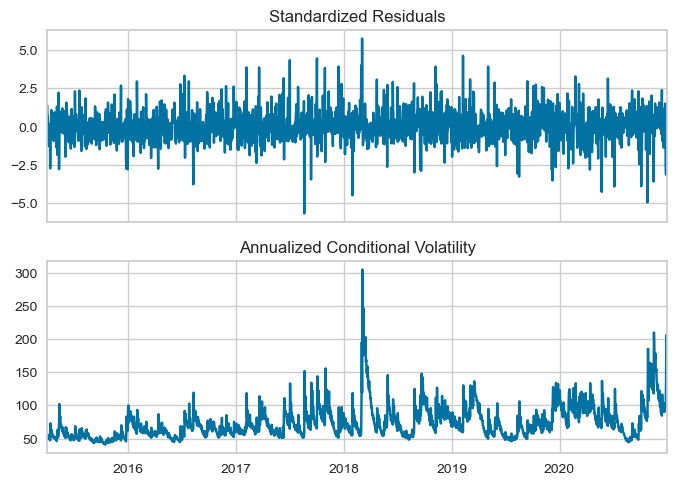

In [170]:
arch_lasso_0.plot(annualize="D");

In [171]:
arch_lasso_0.std_resid

DateTime
2015-04-01    1.386508
2015-04-02   -0.011457
2015-04-03    0.679049
2015-04-04   -0.640947
2015-04-05   -1.215801
                ...   
2020-12-27   -3.139908
2020-12-28    1.468949
2020-12-29    1.162360
2020-12-30    0.906887
2020-12-31    0.780438
Name: std_resid, Length: 2083, dtype: float64

<AxesSubplot:xlabel='std_resid', ylabel='Density'>

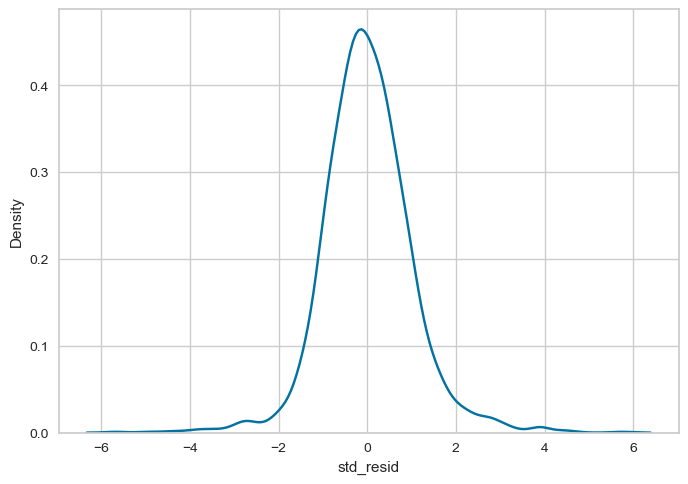

In [172]:
sns.kdeplot(arch_lasso_0.std_resid)

In [174]:
from scipy import stats

x = arch_lasso_0.std_resid

s_w_test = stats.shapiro(x)
s_w_test

ShapiroResult(statistic=0.9611272811889648, pvalue=3.3093715249649265e-23)